# Multiclass Classification
In this notebook, the popularity prediction task is approached as a multiclass classification problem, with each video being assigned one of three popularity classes according to its view count

In [1]:
%cd ..

C:\Users\georg\Documents\msc-project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.evaluation import compare_models, evaluate_model
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import neighbors,svm, ensemble, linear_model, dummy
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv("data/interim/tracks_clean.csv")

The views are split into 3 popularity bins according to the histogram presented in the "Exploration" notebook

In [4]:
popularity_bins = [0,5e+04,1e+06,1e+09]
features = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature',
    'duration_ms'
]

views = df['views']
data = df.loc[views > 0,features]
targets = views[views > 0].apply(np.digitize,bins=popularity_bins)

X, y = data, targets

Text(0, 0.5, 'Video count')

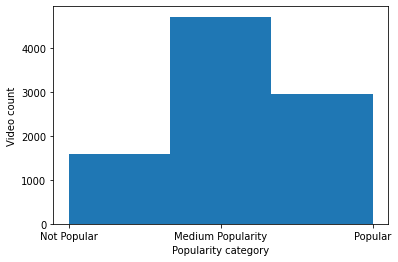

In [5]:
y.hist(bins=3, grid=False)
plt.xticks([1,2,3], labels=["Not Popular","Medium Popularity","Popular"])
plt.xlabel("Popularity category")
plt.ylabel("Video count")

### Combination plots
The diagrams below illustrate the relationship between the different features and the corresponding popularity category

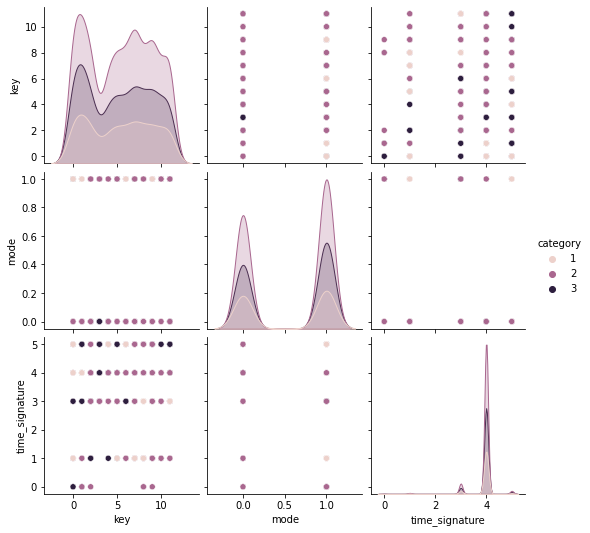

In [6]:
df['category'] = targets
categorical = ['key','mode','time_signature','category']
sns.pairplot(df[views > 0][categorical],hue='category')

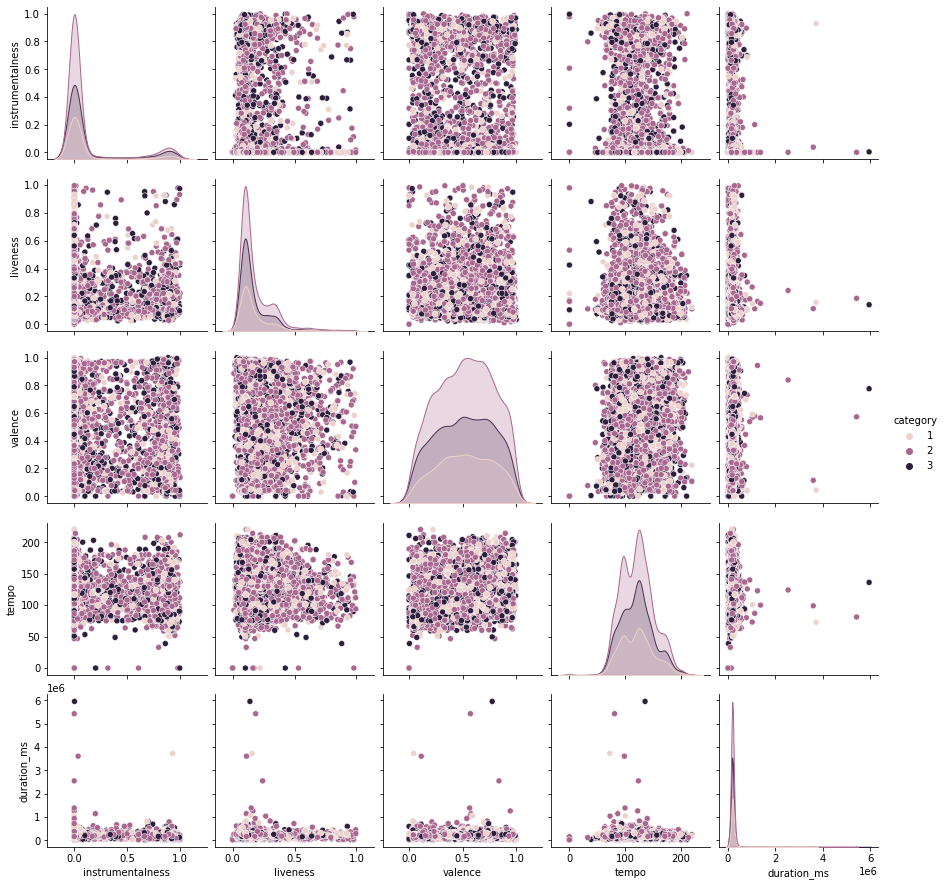

In [7]:
continuous = [
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'category'
]
sns.pairplot(df[views > 0][continuous],hue='category')

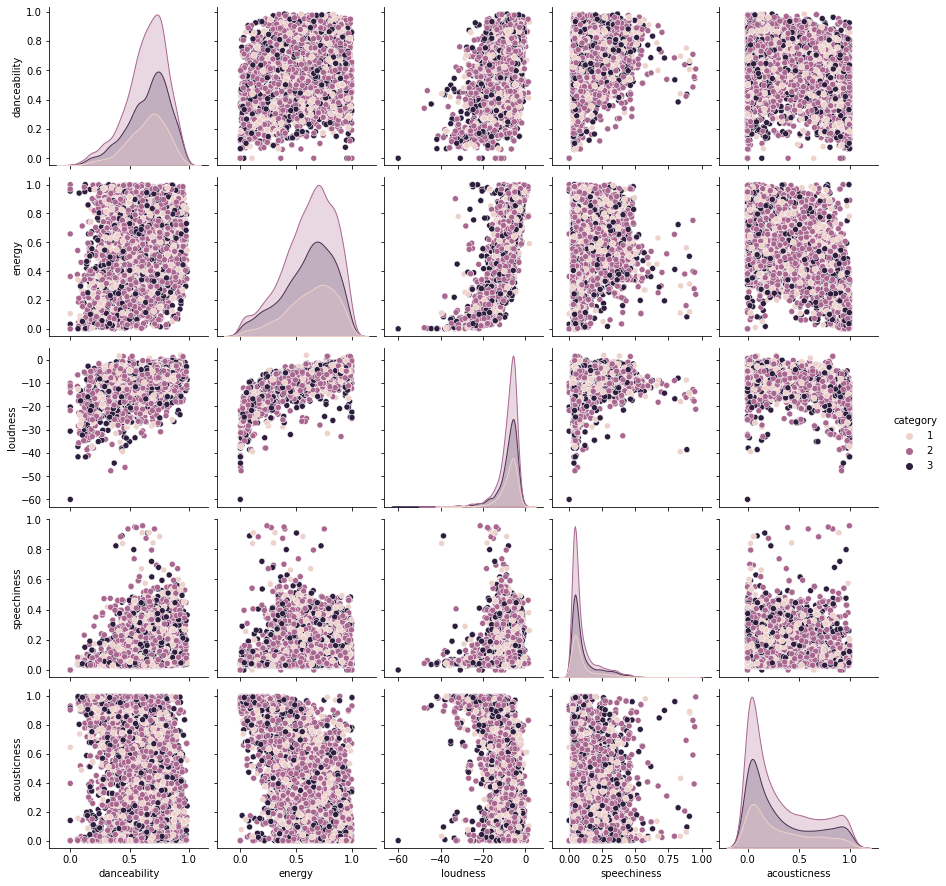

In [8]:
continuous = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'category'
]
sns.pairplot(df[views > 0][continuous],hue='category')

### Model training
Different classification models are trained and evaluated, and the minority classes are oversampled using ADASYN

In [9]:
models = [
    ("Baseline",dummy.DummyClassifier(strategy='stratified')),
    ("5-KNN",neighbors.KNeighborsClassifier(n_neighbors=5)),
    ("10-KNN",neighbors.KNeighborsClassifier(n_neighbors=10)),
    ("SVM Linear", svm.SVC(kernel='linear')),
    ("SVM RBF", svm.SVC(kernel='rbf')),
    ("Random Forest",ensemble.RandomForestClassifier()),
    ("Logistic Regression",linear_model.LogisticRegression())
]
oversampled_models = []
for name, model in models:
    combined = make_pipeline(
        ADASYN(),
        model
    )
    oversampled_models.append((name,combined))
    
metrics = {
    'precision': make_scorer(precision_score,average='macro',zero_division=0),
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}
compare_models(oversampled_models,metrics, data, targets)

Evaluating Baseline
Evaluating 5-KNN
Evaluating 10-KNN
Evaluating SVM Linear
Evaluating SVM RBF
Evaluating Random Forest
Evaluating Logistic Regression


,model,fit_time,score_time,test_precision,test_recall,test_f1
0,Baseline,0.721868,0.005267,0.326036,0.321978,0.310020
1,5-KNN,0.734079,0.401756,0.345466,0.352068,0.326536
2,10-KNN,0.732907,0.455806,0.347912,0.353958,0.326058
3,SVM Linear,9.539259,0.449779,0.339148,0.343345,0.221992
4,SVM RBF,8.579914,1.993918,0.355155,0.363058,0.330811
5,Random Forest,3.587658,0.054958,0.354020,0.354024,0.352692
6,Logistic Regression,0.804409,0.004565,0.356279,0.358750,0.322834


The most promising model in terms of F1 score is the Random Forest classifier. Using a confusion matrix will provide more insight into the performance of the model.

In [21]:
X_train, X_test, y_train,y_test = train_test_split(data, targets)
X_train, y_train = ADASYN().fit_resample(X_train,y_train)
model = ensemble.RandomForestClassifier(class_weight='balanced')
model.fit(X_train,y_train)
predicted = model.predict(X_test)

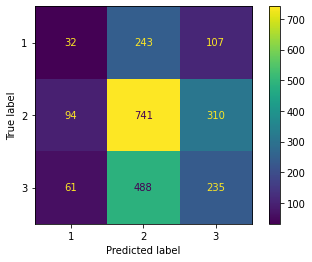

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test,predicted)

In [23]:
evaluate_model(model,['f1_macro'], X_test,y_test)

{'fit_time': array([0.41170597, 0.39630318, 0.40374303, 0.39233518, 0.39533567]),
 'score_time': array([0.01736021, 0.01736021, 0.01835322, 0.01785612, 0.01836228]),
 'test_f1_macro': array([0.30603694, 0.28751358, 0.30059862, 0.30807579, 0.30906171])}